In [ ]:
import os
file_name = ""

# 删除文件
os.remove(file_name)

SAM(Segment Anything Model）是由 Meta 的研究人员团队创建和训练的深度学习模型。该创新成果发表在 2023 年 4 月 5 日发表的一篇研究论文中，它立即引起了公众的广泛兴趣——相关的 Twitter 帖子迄今为止已累积超过 350 万次浏览

1、什么是SAM？
在 Segment everything 研究论文中，SAM 被称为“基础模型”。

基础模型是在大量数据上训练的机器学习模型（通常通过自监督或半监督学习），其目的是在更具体的任务上使用和重新训练。

换句话说，SAM 是一个预训练模型，旨在适应其他任务（特别是通过微调）。

例如，SAM 可以重新训练并用于仅对数据集中的人员进行分割。

人物分割是 SAM 可以执行的一项附件任务，因为它已经在包含此类对象的数据集上进行了训练

2、SAM 是如何训练的？
SAM 在 SA-1B 数据集上进行了训练，该数据集由 Meta 与 Segment Anything 研究论文并行引入。
这些高质量图像（平均 1500×2250 像素）伴随着与数据集标签相对应的 11 亿个分割掩模。

In [1]:
# 下载预训练模型

In [1]:
!pip install git+https://github.com/facebookresearch/segment-anything.git &> /dev/null
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

In [2]:
#MODEL_TYPE：要使用的 SAM 架构
#CHECKPOINT_PATH：包含模型权重的文件的路径
#DEVICE：使用的处理器，“cpu”或“cuda”（如果 GPU 可用）
MODEL_TYPE = "vit_h"
CHECKPOINT_PATH = "/kaggle/working/sam_vit_h_4b8939.pth"
DEVICE = "cuda" #cpu,cuda

In [3]:
# 模型加载
from segment_anything import sam_model_registry

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

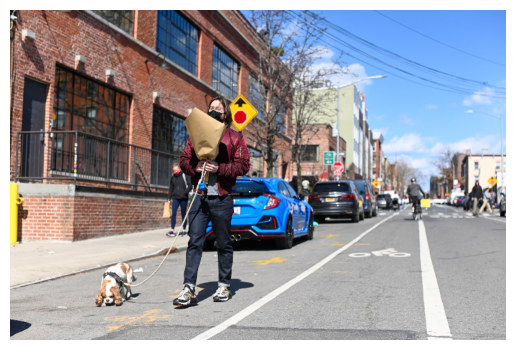

In [9]:
from urllib.request import urlopen
from IPython.display import Image, display
import cv2
import numpy as np
import matplotlib.pyplot as plt

resp = urlopen('https://images.unsplash.com/photo-1615948812700-8828458d368a?ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D&auto=format&fit=crop&w=2072&q=80')
image = np.asarray(bytearray(resp.read()), dtype='uint8')
image = cv2.imdecode(image, cv2.IMREAD_COLOR)
image = cv2.resize(image, (int(image.shape[1]/2.5), int(image.shape[0]/2.5)))

# 保存图像到本地
# cv2.imwrite('output_image.jpg', image)

# 在Colab中显示图像
# display(Image(filename='output_image.jpg'))

# 使用 matplotlib 显示图像
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [10]:
from segment_anything import SamAutomaticMaskGenerator

mask_generator = SamAutomaticMaskGenerator(sam)

In [11]:
masks_generated = mask_generator.generate(image)

In [12]:
print(masks_generated[0].keys())

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


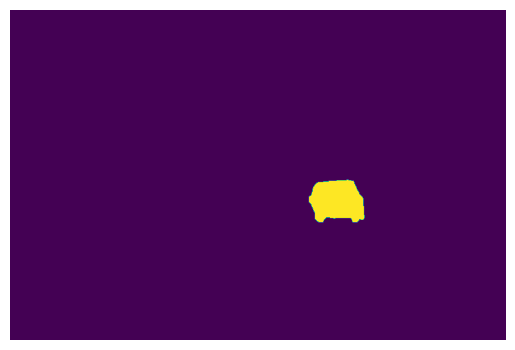

In [13]:

# 保存图像到本地
# cv2.imwrite('masks_generated.jpg',masks_generated[3]['segmentation'].astype(int)*255)

# 在Colab中显示图像
# display(Image(filename='masks_generated.jpg'))

plt.imshow(masks_generated[3]['segmentation'].astype(int)*255)
plt.axis('off')
plt.show()

In [14]:
print('area :', masks_generated[3]['area'])
print('bbox :',masks_generated[3]['bbox'])
print('predicted_iou :',masks_generated[3]['predicted_iou'])
print('point_coords :',masks_generated[3]['point_coords'])
print('stability_score :',masks_generated[3]['stability_score'])
print('crop_box :',masks_generated[3]['crop_box'])

area : 5200
bbox : [499, 284, 92, 70]
predicted_iou : 1.0052757263183594
point_coords : [[582.1875, 318.546875]]
stability_score : 0.981315553188324
crop_box : [0, 0, 828, 551]


In [ ]:
area：遮罩区域（以像素为单位）
bbox：XYWH 格式的掩模边界框
Predicted_iou：模型预测的掩模质量得分
point_coords：生成此掩码的采样输入点
stable_score：额外的掩模质量分数
Crop_box：用于生成 XYWH 格式的此蒙版的图像裁剪

In [15]:
print(len(masks_generated))

111


In [16]:
def draw_masks_fromDict(image, masks_generated):
    masked_image = image.copy()
    for i in range(len(masks_generated)) :
        masked_image = np.where(np.repeat(masks_generated[i]['segmentation'].astype(int)[:, :, np.newaxis], 3, axis=2),
                                np.random.choice(range(256), size=3),
                                masked_image)

        masked_image = masked_image.astype(np.uint8)

    return cv2.addWeighted(image, 0.3, masked_image, 0.7, 0)

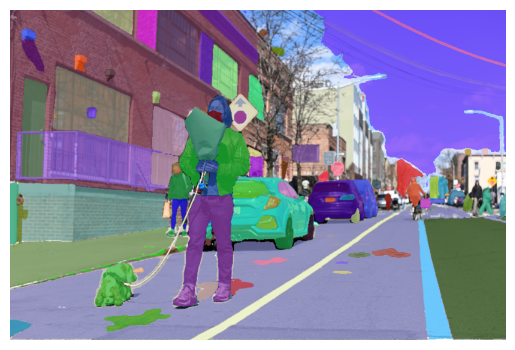

In [17]:
segmented_image = draw_masks_fromDict(image, masks_generated)
# 保存图像到本地
# cv2.imwrite('segmented_image.jpg',segmented_image)

# 在Colab中显示图像
# display(Image(filename='segmented_image.jpg'))

plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [18]:
!pip install ultralytics

  Obtaining dependency information for ultralytics from https://files.pythonhosted.org/packages/f4/79/b192c64e13eefc7f8543a10080767ab057850fa9bdbc38e7c261a3432c93/ultralytics-8.0.227-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 660.5/660.5 kB 21.5 MB/s eta 0:00:00


In [19]:
from ultralytics import YOLO
import numpy as np
from PIL import Image
import requests
from io import BytesIO
import cv2

In [20]:
model = YOLO("yolov8n.pt")

100%|██████████| 6.23M/6.23M [00:00<00:00, 97.6MB/s]


In [21]:
results = model.predict(image)


0: 448x640 5 persons, 7 cars, 1 dog, 62.2ms
Speed: 2.2ms preprocess, 62.2ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)


In [22]:
def box_label(image, box, label='', color=(128, 128, 128), txt_color=(255, 255, 255)):
    lw = max(round(sum(image.shape) / 2 * 0.003), 2)
    p1, p2 = (int(box[0]), int(box[1])), (int(box[2]), int(box[3]))
    cv2.rectangle(image, p1, p2, color, thickness=lw, lineType=cv2.LINE_AA)
    if label:
        tf = max(lw - 1, 1)  # font thickness
        w, h = cv2.getTextSize(label, 0, fontScale=lw / 3, thickness=tf)[0]  # text width, height
        outside = p1[1] - h >= 3
        p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3
        cv2.rectangle(image, p1, p2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(image,
                    label, (p1[0], p1[1] - 2 if outside else p1[1] + h + 2),
                    0,
                    lw / 3,
                    txt_color,
                    thickness=tf,
                    lineType=cv2.LINE_AA)

In [23]:
def plot_bboxes(image, boxes, labels=[], colors=[], score=True, conf=None):
    #Define COCO Labels
    if labels == []:
        labels = {0: u'__background__', 1: u'person', 2: u'bicycle',3: u'car', 4: u'motorcycle', 5: u'airplane', 6: u'bus', 7: u'train', 8: u'truck', 9: u'boat', 10: u'traffic light', 11: u'fire hydrant', 12: u'stop sign', 13: u'parking meter', 14: u'bench', 15: u'bird', 16: u'cat', 17: u'dog', 18: u'horse', 19: u'sheep', 20: u'cow', 21: u'elephant', 22: u'bear', 23: u'zebra', 24: u'giraffe', 25: u'backpack', 26: u'umbrella', 27: u'handbag', 28: u'tie', 29: u'suitcase', 30: u'frisbee', 31: u'skis', 32: u'snowboard', 33: u'sports ball', 34: u'kite', 35: u'baseball bat', 36: u'baseball glove', 37: u'skateboard', 38: u'surfboard', 39: u'tennis racket', 40: u'bottle', 41: u'wine glass', 42: u'cup', 43: u'fork', 44: u'knife', 45: u'spoon', 46: u'bowl', 47: u'banana', 48: u'apple', 49: u'sandwich', 50: u'orange', 51: u'broccoli', 52: u'carrot', 53: u'hot dog', 54: u'pizza', 55: u'donut', 56: u'cake', 57: u'chair', 58: u'couch', 59: u'potted plant', 60: u'bed', 61: u'dining table', 62: u'toilet', 63: u'tv', 64: u'laptop', 65: u'mouse', 66: u'remote', 67: u'keyboard', 68: u'cell phone', 69: u'microwave', 70: u'oven', 71: u'toaster', 72: u'sink', 73: u'refrigerator', 74: u'book', 75: u'clock', 76: u'vase', 77: u'scissors', 78: u'teddy bear', 79: u'hair drier', 80: u'toothbrush'}
    #Define colors
    if colors == []:
        #colors = [(6, 112, 83), (253, 246, 160), (40, 132, 70), (205, 97, 162), (149, 196, 30), (106, 19, 161), (127, 175, 225), (115, 133, 176), (83, 156, 8), (182, 29, 77), (180, 11, 251), (31, 12, 123), (23, 6, 115), (167, 34, 31), (176, 216, 69), (110, 229, 222), (72, 183, 159), (90, 168, 209), (195, 4, 209), (135, 236, 21), (62, 209, 199), (87, 1, 70), (75, 40, 168), (121, 90, 126), (11, 86, 86), (40, 218, 53), (234, 76, 20), (129, 174, 192), (13, 18, 254), (45, 183, 149), (77, 234, 120), (182, 83, 207), (172, 138, 252), (201, 7, 159), (147, 240, 17), (134, 19, 233), (202, 61, 206), (177, 253, 26), (10, 139, 17), (130, 148, 106), (174, 197, 128), (106, 59, 168), (124, 180, 83), (78, 169, 4), (26, 79, 176), (185, 149, 150), (165, 253, 206), (220, 87, 0), (72, 22, 226), (64, 174, 4), (245, 131, 96), (35, 217, 142), (89, 86, 32), (80, 56, 196), (222, 136, 159), (145, 6, 219), (143, 132, 162), (175, 97, 221), (72, 3, 79), (196, 184, 237), (18, 210, 116), (8, 185, 81), (99, 181, 254), (9, 127, 123), (140, 94, 215), (39, 229, 121), (230, 51, 96), (84, 225, 33), (218, 202, 139), (129, 223, 182), (167, 46, 157), (15, 252, 5), (128, 103, 203), (197, 223, 199), (19, 238, 181), (64, 142, 167), (12, 203, 242), (69, 21, 41), (177, 184, 2), (35, 97, 56), (241, 22, 161)]
        colors = [(89, 161, 197),(67, 161, 255),(19, 222, 24),(186, 55, 2),(167, 146, 11),(190, 76, 98),(130, 172, 179),(115, 209, 128),(204, 79, 135),(136, 126, 185),(209, 213, 45),(44, 52, 10),(101, 158, 121),(179, 124, 12),(25, 33, 189),(45, 115, 11),(73, 197, 184),(62, 225, 221),(32, 46, 52),(20, 165, 16),(54, 15, 57),(12, 150, 9),(10, 46, 99),(94, 89, 46),(48, 37, 106),(42, 10, 96),(7, 164, 128),(98, 213, 120),(40, 5, 219),(54, 25, 150),(251, 74, 172),(0, 236, 196),(21, 104, 190),(226, 74, 232),(120, 67, 25),(191, 106, 197),(8, 15, 134),(21, 2, 1),(142, 63, 109),(133, 148, 146),(187, 77, 253),(155, 22, 122),(218, 130, 77),(164, 102, 79),(43, 152, 125),(185, 124, 151),(95, 159, 238),(128, 89, 85),(228, 6, 60),(6, 41, 210),(11, 1, 133),(30, 96, 58),(230, 136, 109),(126, 45, 174),(164, 63, 165),(32, 111, 29),(232, 40, 70),(55, 31, 198),(148, 211, 129),(10, 186, 211),(181, 201, 94),(55, 35, 92),(129, 140, 233),(70, 250, 116),(61, 209, 152),(216, 21, 138),(100, 0, 176),(3, 42, 70),(151, 13, 44),(216, 102, 88),(125, 216, 93),(171, 236, 47),(253, 127, 103),(205, 137, 244),(193, 137, 224),(36, 152, 214),(17, 50, 238),(154, 165, 67),(114, 129, 60),(119, 24, 48),(73, 8, 110)]

    #plot each boxes
    for box in boxes:
        #add score in label if score=True
        if score :
            label = labels[int(box[-1])+1] + " " + str(round(100 * float(box[-2]),1)) + "%"
        else :
            label = labels[int(box[-1])+1]
        #filter every box under conf threshold if conf threshold setted
        if conf :
            if box[-2] > conf:
                color = colors[int(box[-1])]
                box_label(image, box, label, color)
        else:
            color = colors[int(box[-1])]
            box_label(image, box, label, color)

    #show image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
   
    # 使用 matplotlib 显示图像
    plt.imshow(image)
    plt.axis('off')
    plt.show()

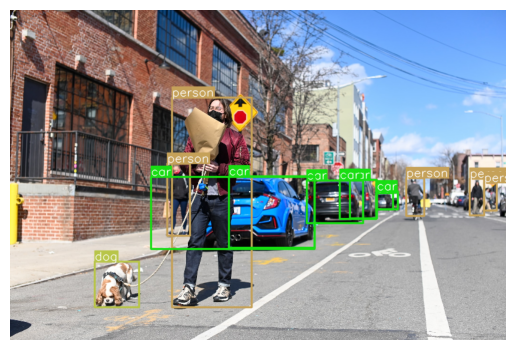

In [24]:
image_bboxes = image.copy()

boxes = np.array(results[0].to('cpu').boxes.data)

plot_bboxes(image_bboxes, boxes, score=False)

In [25]:
print(boxes)

[[     495.96      285.65       589.8      356.48     0.89921           2]
 [     270.63      147.99      403.17      496.82     0.79781           0]
 [     661.67      281.81      691.78      344.07     0.77456           0]
 [     141.31      420.53      215.75      496.14     0.73454          16]
 [     262.67      257.86      300.07       377.2     0.66126           0]
 [     767.02      282.91      791.18      343.76     0.60067           0]
 [     365.42      278.95      508.42      397.27     0.54016           2]
 [     567.31      284.57      612.32      348.26     0.46336           2]
 [     611.79      306.05       639.5       333.8     0.45157           2]
 [     550.34      284.39      611.51      349.38     0.38787           2]
 [     791.37      289.44      812.09      335.93     0.33497           0]
 [     235.32      279.23      508.93      399.63      0.3193           2]
 [     612.13      303.94      647.61      333.11      0.2854           2]]


In [26]:
from segment_anything import SamPredictor

mask_predictor = SamPredictor(sam)

In [27]:
mask_predictor.set_image(image)

In [28]:
# 单个对象检测
mask, _, _ = mask_predictor.predict(
    box=boxes[1][:-2]
)

In [29]:
import cv2
import numpy as np

import cv2
import numpy as np

def draw_mask(image, mask_generated) :
    masked_image = image.copy()

    masked_image = np.where(mask_generated.astype(int),
                      np.array([0,255,0], dtype='uint8'),
                      masked_image)

    masked_image = masked_image.astype(np.uint8)

    return cv2.addWeighted(image, 0.3, masked_image, 0.7, 0)

In [30]:
print(image.shape, mask.shape)

(551, 828, 3) (3, 551, 828)


In [31]:
mask = np.transpose(mask, (1, 2, 0))

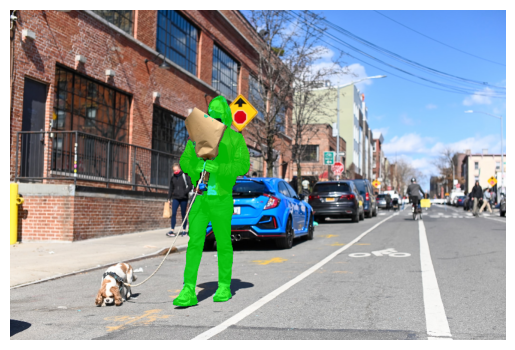

In [32]:
segmented_image = draw_mask(image, mask)

plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [33]:
# 多个对象检测
import torch

input_boxes = torch.tensor(boxes[:, :-2], device=mask_predictor.device)

transformed_boxes = mask_predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])
masks, _, _ = mask_predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)

In [34]:
print(masks.shape)
masks = torch.squeeze(masks, 1)
print(masks.shape)

torch.Size([13, 1, 551, 828])
torch.Size([13, 551, 828])


In [35]:
COLORS = [(89, 161, 197),(67, 161, 255),(19, 222, 24),(186, 55, 2),(167, 146, 11),(190, 76, 98),(130, 172, 179),(115, 209, 128),(204, 79, 135),(136, 126, 185),(209, 213, 45),(44, 52, 10),(101, 158, 121),(179, 124, 12),(25, 33, 189),(45, 115, 11),(73, 197, 184),(62, 225, 221),(32, 46, 52),(20, 165, 16),(54, 15, 57),(12, 150, 9),(10, 46, 99),(94, 89, 46),(48, 37, 106),(42, 10, 96),(7, 164, 128),(98, 213, 120),(40, 5, 219),(54, 25, 150),(251, 74, 172),(0, 236, 196),(21, 104, 190),(226, 74, 232),(120, 67, 25),(191, 106, 197),(8, 15, 134),(21, 2, 1),(142, 63, 109),(133, 148, 146),(187, 77, 253),(155, 22, 122),(218, 130, 77),(164, 102, 79),(43, 152, 125),(185, 124, 151),(95, 159, 238),(128, 89, 85),(228, 6, 60),(6, 41, 210),(11, 1, 133),(30, 96, 58),(230, 136, 109),(126, 45, 174),(164, 63, 165),(32, 111, 29),(232, 40, 70),(55, 31, 198),(148, 211, 129),(10, 186, 211),(181, 201, 94),(55, 35, 92),(129, 140, 233),(70, 250, 116),(61, 209, 152),(216, 21, 138),(100, 0, 176),(3, 42, 70),(151, 13, 44),(216, 102, 88),(125, 216, 93),(171, 236, 47),(253, 127, 103),(205, 137, 244),(193, 137, 224),(36, 152, 214),(17, 50, 238),(154, 165, 67),(114, 129, 60),(119, 24, 48),(73, 8, 110)]

In [36]:
def draw_masks_fromList(image, masks_generated, labels, colors) :
    masked_image = image.copy()
    for i in range(len(masks_generated)) :
        masked_image = np.where(np.repeat(masks_generated[i][:, :, np.newaxis], 3, axis=2),
                                np.asarray(colors[int(labels[i][-1])], dtype='uint8'),
                                masked_image)

        masked_image = masked_image.astype(np.uint8)

    return cv2.addWeighted(image, 0.3, masked_image, 0.7, 0)

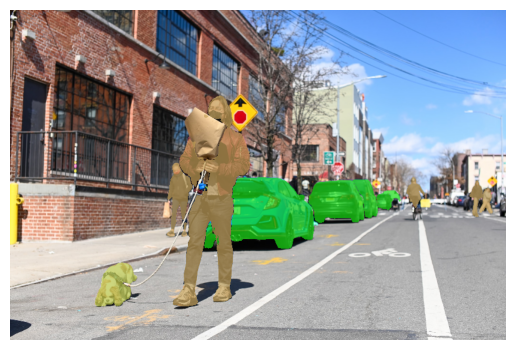

In [37]:
segmented_image = draw_masks_fromList(image, masks.to('cpu'), boxes, COLORS)

plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()